# Model Training: Defencemen - XGBRegressor

The task here will be to train a model to predict that value of NHL players who play the Defence position.

## Import our data

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [3]:
# Load in our data
filepath = '../../Data/Warehouse/MergedData/ML_data.csv' 
data = pd.read_csv(filepath)

In [4]:
defence = data[data['POSITION'].isin(['d, l', 'd'])].copy()

# Select only players with 41 or more games played
defence_41GP = defence[(defence['GP'] >= 41)].copy()
test_train_data = defence_41GP

# Get all numerical features from test_train_data that do not have NaN values
numerical_features = test_train_data.select_dtypes(include=['float64', 'int64']).columns[test_train_data.select_dtypes(include=['float64', 'int64']).isnull().sum() == 0]
numerical_features = numerical_features.drop(['GP', 'AAV', 'SALARY CAP PERCENTAGE', 'SALARY CAP'])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ]
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=500, max_depth=6, reg_lambda=0, eta=0.01))]) # Grid Search optimal n_estimators=500, max_depth=5, reg_lambda=1, eta=0.01

X = test_train_data[numerical_features]
y = test_train_data['SALARY CAP PERCENTAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0005248837453481508


In [5]:
# # Perform Grid Search to find the optimal parameters
# param_grid = {
#     'regressor__n_estimators': [500, 1000, 1500],
#     'regressor__max_depth': [5, 10, 15],
#     'regressor__reg_lambda': [.1, 1, 10],
#     'regressor__eta': [0.01, 0.1, 0.3]
# }

# grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# print(grid_search.best_params_)
# print(grid_search.best_score_)
# print(grid_search.score(X_test, y_test))

# # {'regressor__eta': 0.01, 'regressor__max_depth': 5, 'regressor__n_estimators': 500, 'regressor__reg_lambda': 10}
# # 0.44245590658432327
# # 0.41148105470370877

In [6]:
# Step 2 & 3: Access the trained XGBRegressor model and get feature importances
feature_importances = pipeline.named_steps['regressor'].feature_importances_
features = numerical_features  # This should be the list of features used to train the model

# Step 4: Map feature importances to feature names
importance_dict = dict(zip(features, feature_importances))

# Sort the features by importance
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

# # If you have a large number of features and only want to see the top ones, you can slice the list
# most_important_features = []
# print("Top 10 most important features:")
# for feature, importance in sorted_importances[:10]:
#     print(f"{feature}: {importance}")
#     most_important_features.append(feature)


SF/GP: 0.09333404153585434
CF/GP: 0.042198456823825836
TOI/GP: 0.027965279296040535
DEF. ZONE STARTS/GP: 0.021806398406624794
OFF. ZONE FACEOFFS/GP: 0.019489562138915062
XGA/GP: 0.016543857753276825
FF/GP: 0.015476635657250881
DEF. ZONE FACEOFFS/GP: 0.015309949405491352
SF/60: 0.014412312768399715
HITS TAKEN/60: 0.012864851392805576
XGF/GP: 0.012493511661887169
GA/GP: 0.011413030326366425
LDGF/GP: 0.011020404286682606
GF/GP: 0.010650062002241611
PIM/60: 0.01050665695220232
GA/60: 0.009654632769525051
SA/60: 0.009287607856094837
DEF. ZONE STARTS/60: 0.009280404075980186
FIRST ASSISTS/60: 0.009016596712172031
CA/GP: 0.008915195241570473
MINOR/GP: 0.008894161321222782
SCF/60: 0.008840580470860004
HITS/GP: 0.00868651457130909
HDCA/GP: 0.008614310063421726
CA/60: 0.008597237057983875
ISCF/60: 0.008583305403590202
GIVEAWAYS/60: 0.008501933887600899
NEU. ZONE STARTS/GP: 0.008485667407512665
HDGA/GP: 0.008367999456822872
FA/GP: 0.008344639092683792
TAKEAWAYS/60: 0.008332147262990475
ON THE FLY

In [7]:
def convert_to_dollars(df, col):
    return df[col].map('${:,.2f}'.format)

def invert_convert_to_dollars(df, col):
    return df[col].str.replace('$', '').str.replace(',', '').astype(float)


In [8]:
# Create a feature column in Centers for the predicted salary
defence['PRED_SALARY_PERCENTAGE'] = pipeline.predict(defence)

# Create a column for the actual predicted salary
defence['PRED_AAV'] = defence['PRED_SALARY_PERCENTAGE'] * defence['SALARY CAP']
defence['PRED_AAV'] = defence['PRED_AAV'].astype(int)

# Compute the differential between the predicted and actual salary
defence['DIFF'] = defence['PRED_AAV'] - defence['AAV']

# Convert to dollars
defence['PRED_AAV'] = convert_to_dollars(defence, 'PRED_AAV')
defence['AAV'] = convert_to_dollars(defence, 'AAV')
defence['DIFF'] = convert_to_dollars(defence, 'DIFF')

In [10]:
# Display the full record of the top 20 players based on 'PRED_SALARY_PERCENTAGE' 
top_20 = defence.sort_values('PRED_SALARY_PERCENTAGE', ascending=False).head(25)
display_features = ['PLAYER', 'SEASON']  + ['AAV', 'PRED_AAV', 'DIFF', 'PRED_SALARY_PERCENTAGE'] #  most_important_features
top_20[display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
414,zdeno chara,2007-08,"$7,500,000.00","$7,061,684.00","$-438,316.00",0.140391
10023,erik karlsson,2021-22,"$11,500,000.00","$10,416,601.00","$-1,083,399.00",0.127811
8466,erik karlsson,2019-20,"$11,500,000.00","$10,338,121.00","$-1,161,879.00",0.126848
4875,p.k. subban,2014-15,"$9,000,000.00","$8,571,421.00","$-428,579.00",0.124224
940,zdeno chara,2008-09,"$7,500,000.00","$7,021,124.00","$-478,876.00",0.123829
3396,ryan suter,2012-13,"$7,538,462.00","$7,293,549.00","$-244,913.00",0.121559
11627,erik karlsson,2023-24,"$11,500,000.00","$10,114,159.00","$-1,385,841.00",0.121128
75,chris pronger,2007-08,"$6,250,000.00","$6,089,997.00","$-160,003.00",0.121074
9192,drew doughty,2020-21,"$11,000,000.00","$9,805,449.00","$-1,194,551.00",0.120312
11606,drew doughty,2023-24,"$11,000,000.00","$9,925,110.00","$-1,074,890.00",0.118864


In [11]:
# Display all seasons for Connor McDavid
cale_makar = defence[defence['PLAYER'] == 'cale makar']
cale_makar[display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
8349,cale makar,2019-20,"$2,854,166.00","$1,808,077.00","$-1,046,089.00",0.022185
9096,cale makar,2020-21,"$2,854,166.00","$1,548,863.00","$-1,305,303.00",0.019004
9899,cale makar,2021-22,"$9,000,000.00","$6,043,930.00","$-2,956,070.00",0.074159
11527,cale makar,2023-24,"$9,000,000.00","$6,246,473.00","$-2,753,527.00",0.074808


Text(0.5, 1.0, 'Distribution of Predicted Salary Percentage for Defence')

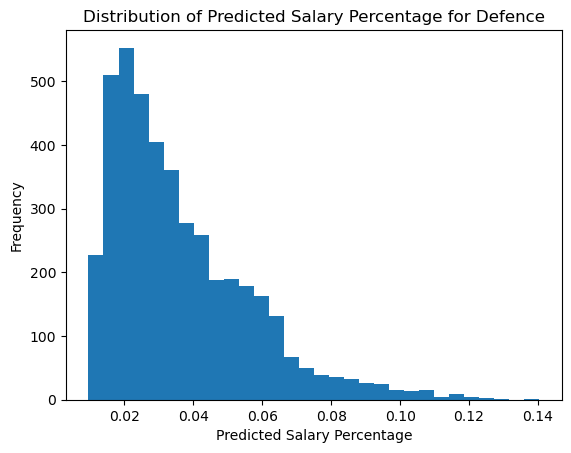

In [12]:
# Plot the distribution of PRED_SALARY_PERCENTAGE
plt.hist(defence['PRED_SALARY_PERCENTAGE'], bins=30)
plt.xlabel('Predicted Percentage of Salary Cap')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Salary Percentage for Defence')

Text(0.5, 1.0, 'Actual Distribution of Salary Cap Percentage for Defence')

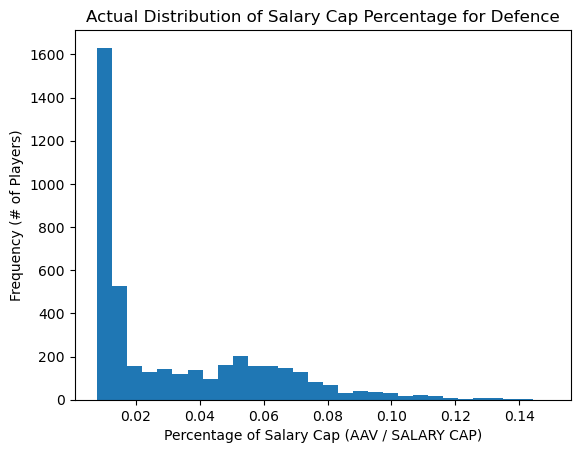

In [16]:
# Plot the distribution of Y_SALARY_CAP_PERCENTAGE
plt.hist(defence['SALARY CAP PERCENTAGE'], bins=30)
plt.xlabel('Percentage of Salary Cap (AAV / SALARY CAP)')
plt.ylabel('Frequency (# of Players)')
plt.title('Actual Distribution of Salary Cap Percentage for Defence')

In [14]:
# Filter players with over 41 GP
filtered_data = defence[(defence['GP'] > 60) & (defence['SEASON'] == '2023-24')].copy()

# Convert AAV and PRED_SALARY_CAP_AAV back to float
filtered_data['AAV'] = invert_convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = invert_convert_to_dollars(filtered_data, 'PRED_AAV')

# Calculate differential between AAV and PRED_SALARY_CAP_AAV
filtered_data['Differential'] = filtered_data['PRED_AAV'] - filtered_data['AAV']

# Sort by differential in descending order
filtered_data = filtered_data.sort_values('Differential', ascending=False)

# Convert AAV and PRED_SALARY_CAP_AAV back to $
filtered_data['AAV'] = convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = convert_to_dollars(filtered_data, 'PRED_AAV')

# Select top 5 players with largest differentials
top_players = filtered_data.head(10)

top_players[['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,SF/GP,CF/GP,TOI/GP,DEF. ZONE STARTS/GP,OFF. ZONE FACEOFFS/GP,XGA/GP,FF/GP,DEF. ZONE FACEOFFS/GP,SF/60,HITS TAKEN/60,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
11695,ott,jake sanderson,2023-24,12.5846,24.6615,23.043333,4.6462,8.0000,1.1077,17.7385,9.3385,32.77,4.73,"$1,850,000.00","$5,200,849.00","$3,350,849.00",0.062286,3350849.0
12074,dal,thomas harley,2023-24,11.2687,23.1343,20.781343,2.9701,8.0746,0.8358,16.3881,6.2388,32.53,5.30,"$1,288,333.00","$3,740,372.00","$2,452,039.00",0.044795,2452039.0
11789,n.j,kevin bahl,2023-24,7.3143,14.5286,17.500476,3.2143,3.8429,0.8571,10.7857,6.2143,25.08,3.92,"$1,050,000.00","$2,674,954.00","$1,624,954.00",0.032035,1624954.0
11706,dal,jani hakanpää,2023-24,7.6719,15.0781,18.646354,4.2969,2.8594,1.0781,10.8438,8.7656,24.69,7.14,"$1,500,000.00","$2,993,756.00","$1,493,756.00",0.035853,1493756.0
11521,min,brock faber,2023-24,12.1571,24.1286,25.089762,4.7000,8.7429,1.3286,17.2000,10.1714,29.07,3.69,"$1,008,333.00","$2,463,822.00","$1,455,489.00",0.029507,1455489.0
12043,ari,sean durzi,2023-24,11.7143,24.0476,22.511111,3.4762,8.8095,1.0794,17.3333,6.0635,31.22,3.64,"$1,700,000.00","$3,080,108.00","$1,380,108.00",0.036888,1380108.0
11927,phi,nick seeler,2023-24,9.4444,17.4444,16.968519,2.9048,4.7937,0.8413,12.8889,5.4444,33.40,3.76,"$775,000.00","$1,916,561.00","$1,141,561.00",0.022953,1141561.0
11534,phi,cam york,2023-24,11.1143,21.4429,22.152381,4.3143,7.6714,1.0857,15.6714,8.0857,30.10,4.60,"$1,600,000.00","$2,655,443.00","$1,055,443.00",0.031802,1055443.0
11784,mtl,kaiden guhle,2023-24,8.5077,16.8615,21.034615,4.0154,4.6769,1.1538,12.3385,8.4308,24.27,5.31,"$1,283,333.00","$2,277,520.00","$994,187.00",0.027276,994187.0
11667,ari,j.j. moser,2023-24,8.5672,18.2985,20.750995,5.0000,5.5224,1.2836,12.7463,8.6418,24.77,5.22,"$925,000.00","$1,858,989.00","$933,989.00",0.022263,933989.0


In [15]:
# Show all players who have a negative differential
filtered_data[filtered_data['Differential'] < 0][['TEAM'] + display_features + ['Differential']].tail(30)

,TEAM,PLAYER,SEASON,SF/GP,CF/GP,TOI/GP,DEF. ZONE STARTS/GP,OFF. ZONE FACEOFFS/GP,XGA/GP,FF/GP,DEF. ZONE FACEOFFS/GP,SF/60,HITS TAKEN/60,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
12024,dal,ryan suter,2023-24,8.8429,18.4714,19.213571,2.8857,5.4857,0.8286,13.2429,6.8429,27.61,2.99,"$3,650,000.00","$3,062,312.00","$-587,688.00",0.036674,-587688.0
11831,cgy,mackenzie weegar,2023-24,12.0441,24.6176,22.468627,3.5294,8.0882,1.2059,17.6471,7.2353,32.16,3.02,"$6,250,000.00","$5,659,288.00","$-590,712.00",0.067776,-590712.0
12065,tor,tj brodie,2023-24,9.9848,19.5152,21.841919,5.0303,5.8182,1.3030,14.1364,9.5000,27.43,5.41,"$5,000,000.00","$4,408,910.00","$-591,090.00",0.052801,-591090.0
11745,n.j,john marino,2023-24,9.1231,18.5077,21.200000,4.6615,4.8308,1.2154,13.1846,9.0000,25.82,3.79,"$4,400,000.00","$3,803,750.00","$-596,250.00",0.045554,-596250.0
11543,bos,charlie mcavoy,2023-24,13.4603,25.9524,24.890212,3.9206,11.6825,1.2381,19.2540,7.9365,32.45,5.09,"$9,500,000.00","$8,850,304.00","$-649,696.00",0.105992,-649696.0
11509,wpg,brenden dillon,2023-24,8.0462,16.5385,18.614872,3.8769,4.0154,1.0769,11.9231,7.6923,25.93,3.52,"$3,900,000.00","$3,158,072.00","$-741,928.00",0.037821,-741928.0
11873,edm,mattias ekholm,2023-24,12.1692,23.8769,20.984103,3.4308,7.6615,0.9538,17.4615,6.5385,34.80,4.05,"$6,250,000.00","$5,433,880.00","$-816,120.00",0.065076,-816120.0
12084,phi,travis sanheim,2023-24,11.7391,22.7391,23.846135,4.8696,7.9855,1.2174,16.7391,8.9710,29.54,4.52,"$6,250,000.00","$5,417,338.00","$-832,662.00",0.064878,-832662.0
12123,l.a,vladislav gavrikov,2023-24,11.0000,20.7344,20.644792,4.0312,5.7812,1.0781,15.5781,8.2031,31.97,1.73,"$5,875,000.00","$5,035,537.00","$-839,463.00",0.060306,-839463.0
11628,dal,esa lindell,2023-24,9.1571,17.6571,20.369286,4.5571,3.8143,1.1714,12.8571,9.9714,26.97,5.60,"$5,800,000.00","$4,957,368.00","$-842,632.00",0.059370,-842632.0


In [16]:
# Show all players who have a positive differential
filtered_data[filtered_data['Differential'] > 0][['TEAM'] + display_features + ['Differential']].head(30)

,TEAM,PLAYER,SEASON,SF/GP,CF/GP,TOI/GP,DEF. ZONE STARTS/GP,OFF. ZONE FACEOFFS/GP,XGA/GP,FF/GP,DEF. ZONE FACEOFFS/GP,SF/60,HITS TAKEN/60,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
11695,ott,jake sanderson,2023-24,12.5846,24.6615,23.043333,4.6462,8.0000,1.1077,17.7385,9.3385,32.77,4.73,"$1,850,000.00","$5,200,849.00","$3,350,849.00",0.062286,3350849.0
12074,dal,thomas harley,2023-24,11.2687,23.1343,20.781343,2.9701,8.0746,0.8358,16.3881,6.2388,32.53,5.30,"$1,288,333.00","$3,740,372.00","$2,452,039.00",0.044795,2452039.0
11789,n.j,kevin bahl,2023-24,7.3143,14.5286,17.500476,3.2143,3.8429,0.8571,10.7857,6.2143,25.08,3.92,"$1,050,000.00","$2,674,954.00","$1,624,954.00",0.032035,1624954.0
11706,dal,jani hakanpää,2023-24,7.6719,15.0781,18.646354,4.2969,2.8594,1.0781,10.8438,8.7656,24.69,7.14,"$1,500,000.00","$2,993,756.00","$1,493,756.00",0.035853,1493756.0
11521,min,brock faber,2023-24,12.1571,24.1286,25.089762,4.7000,8.7429,1.3286,17.2000,10.1714,29.07,3.69,"$1,008,333.00","$2,463,822.00","$1,455,489.00",0.029507,1455489.0
12043,ari,sean durzi,2023-24,11.7143,24.0476,22.511111,3.4762,8.8095,1.0794,17.3333,6.0635,31.22,3.64,"$1,700,000.00","$3,080,108.00","$1,380,108.00",0.036888,1380108.0
11927,phi,nick seeler,2023-24,9.4444,17.4444,16.968519,2.9048,4.7937,0.8413,12.8889,5.4444,33.40,3.76,"$775,000.00","$1,916,561.00","$1,141,561.00",0.022953,1141561.0
11534,phi,cam york,2023-24,11.1143,21.4429,22.152381,4.3143,7.6714,1.0857,15.6714,8.0857,30.10,4.60,"$1,600,000.00","$2,655,443.00","$1,055,443.00",0.031802,1055443.0
11784,mtl,kaiden guhle,2023-24,8.5077,16.8615,21.034615,4.0154,4.6769,1.1538,12.3385,8.4308,24.27,5.31,"$1,283,333.00","$2,277,520.00","$994,187.00",0.027276,994187.0
11667,ari,j.j. moser,2023-24,8.5672,18.2985,20.750995,5.0000,5.5224,1.2836,12.7463,8.6418,24.77,5.22,"$925,000.00","$1,858,989.00","$933,989.00",0.022263,933989.0


In [17]:
filtered_data[filtered_data['PLAYER'] == 'quinn hughes'][['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,SF/GP,CF/GP,TOI/GP,DEF. ZONE STARTS/GP,OFF. ZONE FACEOFFS/GP,XGA/GP,FF/GP,DEF. ZONE FACEOFFS/GP,SF/60,HITS TAKEN/60,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
11983,van,quinn hughes,2023-24,14.0429,29.8429,24.723333,2.4857,10.4571,1.0286,21.0714,5.3429,34.08,3.09,"$7,850,000.00","$7,405,115.00","$-444,885.00",0.088684,-444885.0


In [19]:
predictions = pd.DataFrame(defence[['PLAYER', 'SEASON', 'TOI/GP', 'PRED_SALARY_PERCENTAGE']])

# Save predictions to disk
save_dir = '../../Data/Warehouse/Predictions/' 
filename = 'defence_predictions.csv'

# Check if the directory exists, if not create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the predictions to disk
predictions.to_csv(save_dir + filename, index=False)